# Artificial Intelligence: ML

Alexandru Sima (332CA)


In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk

## t


In [23]:
frame = pd.read_csv("datasets/air_pollution_full.csv")
print(frame)

       Unnamed: 0                   Country              City  AQI_Value  \
0               0        Russian Federation        Praskoveya         51   
1               1                    Brazil  Presidente Dutra         41   
2               2                     Italy   Priolo Gargallo         66   
3               3                    Poland         Przasnysz         34   
4               4                    France          Punaauia         22   
...           ...                       ...               ...        ...   
23458       23458                     India      Gursahaiganj        184   
23459       23459                    France            Sceaux         50   
23460       23460                     India          Mormugao         50   
23461       23461  United States of America       Westerville         71   
23462       23462                  Malaysia            Marang         70   

      AQI_Category  CO_Value CO_Category  Ozone_Value Ozone_Category  \
0         Moder

In [24]:
def print_numeric_info(data: pd.DataFrame):


_IncompleteInputError: incomplete input (945945667.py, line 1)

In [ ]:
def print_categorical_info(data: pd.DataFrame):
    print(data.describe())

    for col in data.columns:
        data[col].value_counts().plot.hist()
        plt.title(col)
        plt.show()

In [ ]:
def print_label_info(data: pd.Series):
    data.value_counts().plot.bar()
    plt.show()

In [ ]:
numeric_attrs, categorical_attrs, labels = split_air_pollution_data(frame)

In [ ]:
def print_info(data: pd.DataFrame):
    numeric, categorical, labels = split_air_pollution_data(data)
    print_numeric_info(numeric)
    print_categorical_info(categorical)
    print_label_info(labels)

## Preprocessing


In [ ]:
def preprocess_data(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    numeric, categorical, labels = split_air_pollution_data(data)
    numeric = autocomplete_data(numeric)

    encoder = sk.preprocessing.LabelEncoder()
    encoder.fit(labels)
    labels = encoder.transform(labels)

    del numeric["PM25_Value"]
    del numeric["VOCs"]

    encoder = sk.preprocessing.LabelEncoder()
    for col in categorical.columns:
        encoder.fit(categorical[col])
        categorical.loc[:, col] = encoder.transform(categorical[col])

    numeric = scale_data(numeric)
    return pd.concat([numeric, categorical], axis=1), labels

In [ ]:
# print_numeric_info(scale_data(numeric_attrs))
new_data = preprocess_data(frame)
# print_numeric_info(new_data)

## Machine Learning


In [ ]:
model = "air_pollution"
train_data = f"datasets/{model}_train.csv"
test_data = f"datasets/{model}_test.csv"

train_data = pd.read_csv(train_data)
test_data = pd.read_csv(test_data)

train_data, labels = preprocess_data(train_data)
test_data, test_labels = preprocess_data(test_data)

In [ ]:
# classifier = sk.ensemble.RandomForestClassifier()
# classifier = sk.linear_model.LogisticRegression()
classifier = sk.neural_network.MLPClassifier()
classifier.fit(train_data, labels)
predictions = classifier.predict(train_data)
print(classifier.score(test_data, test_labels))
print(predictions)

## Air pollution


In [ ]:
raw_train_data = pd.read_csv("datasets/air_pollution_test.csv")
print(raw_train_data)

In [ ]:
NUMERIC_COLUMNS = [
    "AQI_Value",
    "CO_Value",
    "Ozone_Value",
    "NO2_Value",
    "PM25_Value",
    "VOCs",
    "SO2",
]
CATEGORICAL_COLUMNS = [
    "Country",
    "City",
    "CO_Category",
    "Ozone_Category",
    "NO2_Category",
    "PM25_Category",
    "Emissions",
]
LABEL_COLUMNS = "AQI_Category"


def split_pollution_data(
    data: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    numeric_attrs = [attr for attr in NUMERIC_COLUMNS if attr in data.columns]
    categorical_attrs = [attr for attr in CATEGORICAL_COLUMNS if attr in data.columns]

    numeric_attrs = data[numeric_attrs]
    categorical_attrs = data[categorical_attrs]
    labels = data[LABEL_COLUMNS]

    return numeric_attrs, categorical_attrs, labels


num_train_data, cat_train_data, train_labels = split_pollution_data(raw_train_data)

### Exploratory data analysis


In [ ]:
print(num_train_data.describe())
num_train_data.boxplot()
plt.show()

#### Atribute corellation


In [ ]:
correlation = num_train_data.corr()
plt.matshow(correlation)
plt.colorbar()
plt.show()

### Preprocessing


#### Imputing missing data


In [ ]:
def impute_missing_numerical_data(data: pd.DataFrame) -> pd.DataFrame:
    imputer = sk.impute.SimpleImputer()
    imputer.fit(data)

    imputed_data = imputer.transform(data)
    return pd.DataFrame(imputed_data, columns=data.columns)


num_train_data = impute_missing_numerical_data(num_train_data)

In [ ]:
def impute_missing_categorical_data(data: pd.DataFrame) -> pd.DataFrame:
    imputer = sk.impute.SimpleImputer(strategy="most_frequent")
    imputer.fit(data)

    imputed_data = imputer.transform(data)
    return pd.DataFrame(imputed_data, columns=data.columns)


cat_train_data = impute_missing_categorical_data(cat_train_data)

#### Extreme values


#### Redundant attributes


We can see from the correlation matrix that columns _0_, _4_ and _5_ are very
strongly correlated (correlation index is **$\approx$ 1**), so, we can remove,
for example, columns _4_ and _5_.


In [ ]:
def remove_redundant_attributes(data: pd.DataFrame):
    del data["PM25_Value"]
    del data["VOCs"]


remove_redundant_attributes(num_train_data)

#### Domain standardization


In [ ]:
def scale_data(data: pd.DataFrame) -> pd.DataFrame:
    scaler = sk.preprocessing.StandardScaler()
    scaler.fit(data)

    scaled_data = scaler.transform(data)
    return pd.DataFrame(scaled_data, columns=data.columns)


num_train_data = scale_data(num_train_data)

#### Categorical attributes encoding


In [ ]:
def encode_categorical_attributes(data: pd.DataFrame):
    encoder = sk.preprocessing.LabelEncoder()

    for col in data.columns:
        encoder.fit(data[col])
        data.loc[:, col] = encoder.transform(data[col])


encode_categorical_attributes(cat_train_data)

In [ ]:
def encode_labels(data: pd.Series) -> pd.Series:
    encoder = sk.preprocessing.LabelEncoder()
    encoder.fit(data)

    return encoder.transform(data)


train_labels = encode_labels(train_labels)

### Prediction


In [ ]:
train_data = pd.concat([num_train_data, cat_train_data], axis=1)
print(train_data)

#### Test data


In [ ]:
raw_test_data = pd.read_csv("datasets/air_pollution_test.csv")
print(raw_test_data)

In [ ]:
num_test_data, cat_test_data, test_labels = split_pollution_data(raw_test_data)

In [ ]:
num_test_data = impute_missing_numerical_data(num_test_data)
cat_test_data = impute_missing_categorical_data(cat_test_data)
num_test_data = scale_data(num_test_data)
remove_redundant_attributes(num_test_data)
encode_categorical_attributes(cat_test_data)

In [ ]:
test_labels = encode_labels(test_labels)
test_data = pd.concat([num_test_data, cat_test_data], axis=1)
print(test_data)

#### Decision Tree


In [ ]:
def run_classifier(classifier, test_data: pd.DataFrame, test_labels: pd.Series):
    sk.metrics.ConfusionMatrixDisplay.from_estimator(
        classifier,
        test_data,
        test_labels,
    )
    plt.show()

    predictions = classifier.predict(test_data)
    print("predicted values:", predictions)
    print("actual values:", test_labels)


classifier = sk.tree.DecisionTreeClassifier()
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)

#### Random forest


In [ ]:
classifier = sk.ensemble.RandomForestClassifier()
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)

#### Logistic regression


In [ ]:
classifier = sk.linear_model.LogisticRegression(max_iter=10000)
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)

#### Multi-layered perceptron


In [ ]:
classifier = sk.neural_network.MLPClassifier()
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)

## News popularity


In [31]:
raw_train_data = pd.read_csv("datasets/news_popularity_train.csv")
print(raw_train_data)

                                                     url  \
0      http://mashable.com/2014/06/09/instagram-inter...   
1      http://mashable.com/2014/02/23/drug-test-marij...   
2      http://mashable.com/2013/05/14/hunger-games-ca...   
3      http://mashable.com/2014/11/26/dancing-with-th...   
4      http://mashable.com/2013/02/05/att-ad-targetin...   
...                                                  ...   
31710  http://mashable.com/2014/02/12/house-of-cards-...   
31711  http://mashable.com/2014/10/27/gotham-robin-lo...   
31712  http://mashable.com/2014/04/14/fruit-of-the-lo...   
31713   http://mashable.com/2013/11/18/alien-bonds-seti/   
31714  http://mashable.com/2013/04/29/yahoo-introduce...   

        days_since_published   title_word_count   content_word_count  \
0                      213.0               12.0               1966.0   
1                      319.0                9.0               1396.0   
2                      604.0                9.0                

In [50]:
NUMERIC_COLUMNS = [
    " days_since_published",
    " title_word_count",
    " content_word_count",
    " unique_word_ratio",
    " non_stop_word_ratio",
    " unique_non_stop_ratio",
    " external_links",
    " internal_links",
    " image_count",
    " video_count",
    " avg_word_length",
    " keyword_count",
    " keyword_worst_min_shares",
    " keywords_worst_max_shares",
    " keyword_worst_avg_shares",
    " keyword_best_min_shares",
    " keyword_best_max_shares",
    " keyword_best_avg_shares",
    " keyword_avg_min_shares",
    " keyword_avg_max_shares",
    " keyword_avg_avg_shares",
    " ref_min_shares",
    " ref_max_shares",
    " ref_avg_shares",
    " topic_0_relevance",
    " topic_1_relevance",
    " topic_2_relevance",
    " topic_3_relevance",
    " topic_4_relevance",
    " content_subjectivity",
    " content_sentiment",
    " positive_word_rate",
    " negative_word_rate",
    " non_neutral_positive_rate",
    " non_neutral_negative_rate",
    " avg_positive_sentiment",
    " min_positive_sentiment",
    " max_positive_sentiment",
    " avg_negative_sentiment",
    " min_negative_sentiment",
    " max_negative_sentiment",
    " title_subjectivity",
    " title_sentiment",
    " title_subjectivity_magnitude",
    " title_sentiment_magnitude",
    " engagement_ratio",
    " content_density",
]
CATEGORICAL_COLUMNS = [
    "url",
    " channel_lifestyle",
    " channel_entertainment",
    " channel_business",
    " channel_social_media",
    " channel_tech",
    " channel_world",
    " day_monday",
    " day_tuesday",
    " day_wednesday",
    " day_thursday",
    " day_friday",
    " day_saturday",
    " day_sunday",
    " is_weekend",
    " publication_period",
]
LABEL_COLUMNS = "popularity_category"

In [54]:
def split_news_data(
    data: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    numeric_attrs = [attr for attr in NUMERIC_COLUMNS if attr in data.columns]
    categorical_attrs = [attr for attr in CATEGORICAL_COLUMNS if attr in data.columns]

    numeric_attrs = data[numeric_attrs]
    categorical_attrs = data[categorical_attrs]
    labels = data[LABEL_COLUMNS]

    return numeric_attrs, categorical_attrs, labels


num_train_data, cat_train_data, train_labels = split_news_data(raw_train_data)
print(num_train_data)
print(cat_train_data)
print(train_labels)

       days_since_published  title_word_count  content_word_count  \
0                     213.0              12.0              1966.0   
1                     319.0               9.0              1396.0   
2                     604.0               9.0               137.0   
3                      41.0              13.0               591.0   
4                     702.0              12.0               786.0   
...                     ...               ...                 ...   
31710                 330.0              11.0               123.0   
31711                  72.0               7.0               259.0   
31712                 269.0               9.0               163.0   
31713                 416.0              11.0              1191.0   
31714                 619.0               7.0               268.0   

       unique_word_ratio  non_stop_word_ratio  unique_non_stop_ratio  \
0               0.404288                  1.0               0.631103   
1               0.388092   

### Exploratory data analysis


In [ ]:
print(num_train_data.describe())
num_train_data.boxplot()
plt.show()

#### Atribute corellation


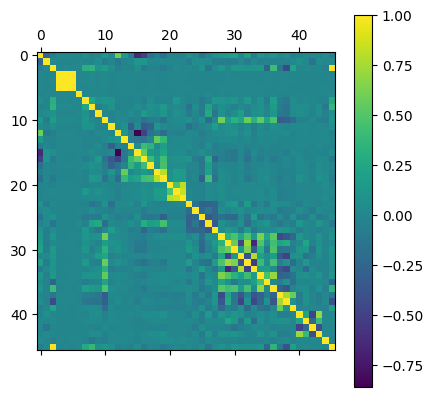

In [55]:
correlation = num_train_data.corr()
plt.matshow(correlation)
plt.colorbar()
plt.show()

### Preprocessing


#### Imputing missing data


In [56]:
def impute_missing_numerical_data(data: pd.DataFrame) -> pd.DataFrame:
    imputer = sk.impute.SimpleImputer()
    imputer.fit(data)

    imputed_data = imputer.transform(data)
    return pd.DataFrame(imputed_data, columns=data.columns)


num_train_data = impute_missing_numerical_data(num_train_data)

In [57]:
def impute_missing_categorical_data(data: pd.DataFrame) -> pd.DataFrame:
    imputer = sk.impute.SimpleImputer(strategy="most_frequent")
    imputer.fit(data)

    imputed_data = imputer.transform(data)
    return pd.DataFrame(imputed_data, columns=data.columns)


cat_train_data = impute_missing_categorical_data(cat_train_data)

#### Extreme values


#### Redundant attributes


We can see from the correlation matrix that columns _0_, _4_ and _5_ are very
strongly correlated (correlation index is **$\approx$ 1**), so, we can remove,
for example, columns _4_ and _5_.


In [ ]:
def remove_redundant_attributes(data: pd.DataFrame):
    del data["PM25_Value"]
    del data["VOCs"]


remove_redundant_attributes(num_train_data)

#### Domain standardization


In [58]:
def scale_data(data: pd.DataFrame) -> pd.DataFrame:
    scaler = sk.preprocessing.StandardScaler()
    scaler.fit(data)

    scaled_data = scaler.transform(data)
    return pd.DataFrame(scaled_data, columns=data.columns)


num_train_data = scale_data(num_train_data)

#### Categorical attributes encoding


In [59]:
def encode_categorical_attributes(data: pd.DataFrame):
    encoder = sk.preprocessing.LabelEncoder()

    for col in data.columns:
        encoder.fit(data[col])
        data.loc[:, col] = encoder.transform(data[col])


encode_categorical_attributes(cat_train_data)

In [60]:
def encode_labels(data: pd.Series) -> pd.Series:
    encoder = sk.preprocessing.LabelEncoder()
    encoder.fit(data)

    return encoder.transform(data)


train_labels = encode_labels(train_labels)

### Prediction


In [61]:
train_data = pd.concat([num_train_data, cat_train_data], axis=1)
print(train_data)

       days_since_published  title_word_count  content_word_count  \
0                 -0.662791          0.756254            3.015774   
1                 -0.167466         -0.661247            1.805005   
2                  1.164304         -0.661247           -0.869306   
3                 -1.466526          1.228755            0.095061   
4                  1.622245          0.756254            0.509271   
...                     ...               ...                 ...   
31710             -0.116064          0.283754           -0.899044   
31711             -1.321666         -1.606248           -0.610159   
31712             -0.401110         -0.661247           -0.814078   
31713              0.285803          0.283754            1.369554   
31714              1.234397         -1.606248           -0.591041   

       unique_word_ratio  non_stop_word_ratio  unique_non_stop_ratio  \
0              -0.037633             -0.00041              -0.016940   
1              -0.041749   

#### Test data


In [62]:
raw_test_data = pd.read_csv("datasets/news_popularity_test.csv")
print(raw_test_data)

                                                    url  \
0     http://mashable.com/2013/07/31/hogwarts-tv-cha...   
1     http://mashable.com/2014/03/11/kid-cupcakes-di...   
2     http://mashable.com/2014/04/26/animals-with-hi...   
3     http://mashable.com/2014/04/14/lana-del-rey-we...   
4     http://mashable.com/2013/01/28/nfl-commissione...   
...                                                 ...   
7924  http://mashable.com/2013/12/13/google-autocomp...   
7925  http://mashable.com/2013/06/25/google-chrome-c...   
7926  http://mashable.com/2014/09/10/obama-address-i...   
7927  http://mashable.com/2014/08/13/reporters-fergu...   
7928         http://mashable.com/2013/04/11/storypress/   

       days_since_published   title_word_count   content_word_count  \
0                     526.0                8.0                332.0   
1                     303.0                8.0                161.0   
2                     257.0                9.0                506.0   
3      

In [65]:
num_test_data, cat_test_data, test_labels = split_pollution_data(raw_test_data)

In [66]:
num_test_data = impute_missing_numerical_data(num_test_data)
cat_test_data = impute_missing_categorical_data(cat_test_data)
num_test_data = scale_data(num_test_data)
# remove_redundant_attributes(num_test_data)
encode_categorical_attributes(cat_test_data)

In [67]:
test_labels = encode_labels(test_labels)
test_data = pd.concat([num_test_data, cat_test_data], axis=1)
print(test_data)

      days_since_published  title_word_count  content_word_count  \
0                 0.804016         -1.138502           -0.456354   
1                -0.234180         -1.138502           -0.818334   
2                -0.448336         -0.663312           -0.088024   
3                -0.392469          0.287068            1.681655   
4                 1.660643         -0.188122            0.788348   
...                    ...               ...                 ...   
7924              0.175512          0.287068           -0.850086   
7925              0.971617          0.762258           -0.428835   
7926             -1.090807         -0.188122           -0.613000   
7927             -0.960451         -1.138502            1.264638   
7928              1.320785          0.762258           -0.723076   

      unique_word_ratio  non_stop_word_ratio  unique_non_stop_ratio  \
0              0.482469             0.167346               0.479425   
1              1.565908             0.167

#### Decision Tree


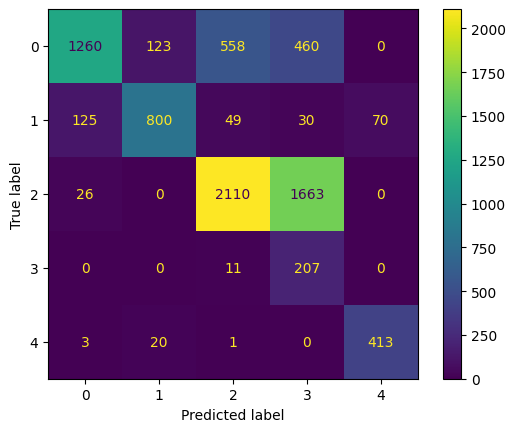

predicted values: [0 2 0 ... 2 3 0]
actual values: [0 2 0 ... 0 2 0]


In [68]:
def run_classifier(classifier, test_data: pd.DataFrame, test_labels: pd.Series):
    sk.metrics.ConfusionMatrixDisplay.from_estimator(
        classifier,
        test_data,
        test_labels,
    )
    plt.show()

    predictions = classifier.predict(test_data)
    print("predicted values:", predictions)
    print("actual values:", test_labels)


classifier = sk.tree.DecisionTreeClassifier()
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)

#### Random forest


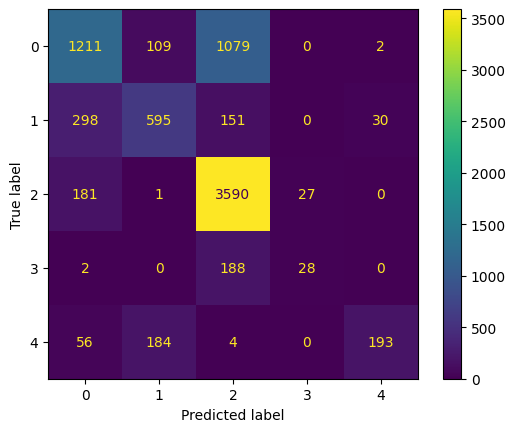

predicted values: [0 2 0 ... 2 2 0]
actual values: [0 2 0 ... 0 2 0]


In [69]:
classifier = sk.ensemble.RandomForestClassifier()
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)

#### Logistic regression


In [ ]:
classifier = sk.linear_model.LogisticRegression(max_iter=10000)
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)

#### Multi-layered perceptron


In [ ]:
classifier = sk.neural_network.MLPClassifier()
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)